In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Cahn-Hilliard Benchmark Simulation
This is a simple example of a the solution of a phase-field model using a pseudo-spectral method. The example problem is from PFHub Benchmark 1a:
https://pages.nist.gov/pfhub/benchmarks/benchmark1.ipynb/

which is a deterministic simulation of spinodal decomposition using the Cahn-Hilliard equation.

The version of the Cahn-Hilliard in the benchmark problem is given by:

$\frac{\partial c}{\partial t} = \nabla \cdot \left[M \nabla \left( \frac{\partial f_{chem}}{\partial c} - \kappa \nabla^2 c \right) \right]$

where:

$\frac{\partial f_{chem}}{\partial c} = 2 \rho_{s} \left[ (c-c_{\alpha})(c_{\beta}-c)^2 - (c-c_{\alpha})^2(c_{\beta}-c) \right]$

In this notebook we solve the benchmark problem using a pseudo-spectral spatial discretization and a semi-implicit temporal discretization using backward Euler (where the current time step is given by the index $n$:

$\frac{c^{n+1}-c^n}{\Delta t} = \nabla \cdot \left[M \nabla \left( \frac{\partial f_{chem}}{\partial c}^n - \kappa \nabla^2 c^{n+1} \right) \right]$

In Fourier space, this becomes:

$\frac{\tilde{c}^{n+1}-\tilde{c}^n}{\Delta t} = M (k_x^2 + k_y^2) \left( \tilde{\frac{\partial f_{chem}}{\partial c}}^n - \kappa (k_x^2 + k_y^2) \tilde{c}^{n+1} \right)$

$\frac{\partial \tilde{c}}{\partial t} = M (k_x^2 + k_y^2) \tilde{\frac{\partial f_{chem}}{\partial c}} - M \kappa (k_x^2 + k_y^2)^2 \tilde{c} $



$\tilde{c}^{n+1} = \Large\frac{\tilde{c}^n + \Delta t M (k_x^2 + k_y^2) \tilde{{\frac{\partial f_{chem}}{\partial c}}}^n} { 1.0 + \Delta t M \kappa (k_x^2 + k_y^2)^2}$

Commented out, we also have a fully explicit implementation with forward Euler:

$\frac{c^{n+1}-c^n}{\Delta t} = \nabla \cdot \left[M \nabla \left( \frac{\partial f_{chem}}{\partial c}^n - \kappa \nabla^2 c^{n} \right) \right]$

# Function to get the wave numbers: `kx`, `ky`

In [2]:
def get_wave_numbers(Nx,Ny):
    kx = np.zeros(X.shape, dtype=complex)
    ky = np.zeros(X.shape, dtype=complex)

    for i in range(0,Nx):
        for j in range(0,Ny):

            kx[i][j] = i;
            ky[i][j] = j;

            if (i>Nx/2):
                kx[i][j] = i - Nx
            if (j>Ny/2):
                ky[i][j] = j - Ny


            if (2*i == Nx):
                kx[i][j] = 0.0
            if (2*j == Ny):
                ky[i][j] = 0.0

    kx = kx * 2.0 * math.pi * complex(0,1)/Nx
    ky = ky * 2.0 * math.pi * complex(0,1)/Ny
    
    return (kx, ky)

# Model Constants

In [3]:
M = 5.
kappa = 2.
c_alpha = 0.3
c_beta = 0.7
rho = 5.

c_0 = 0.5
eps = 0.01

domain_size = 200.

## Define the mesh, number of time steps, and time step size

In [4]:
n_time_steps = 500
dt = 0.5

Nx, Ny = (96, 96)
hx = domain_size/Nx
hy = domain_size/Ny
x = hx*np.arange(0,Nx)
y = hy*np.arange(0,Ny)
X,Y = np.meshgrid(x,y, indexing='ij')
(kx, ky) = get_wave_numbers(Nx,Ny) 

## Set the initial conditions and perform the simulation

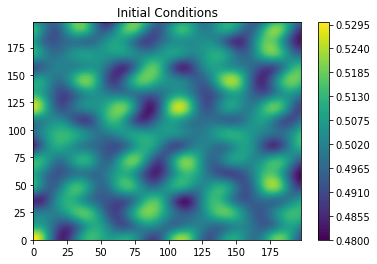

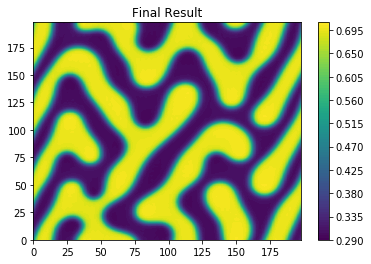

In [5]:
# Allocate variables
c = np.zeros(X.shape, dtype=complex)
df_dc = np.zeros(X.shape, dtype=complex)
c_hat = np.zeros(X.shape, dtype=complex)
df_dc_hat = np.zeros(X.shape, dtype=complex)

# Set initial conditions
c = c_0 + eps * (np.cos(0.105*X)*np.cos(0.11*Y)+(np.cos(0.13*X)*np.cos(0.087*Y))*(np.cos(0.13*X)*np.cos(0.087*Y)) + np.cos(0.025*X-0.15*Y)*np.cos(0.07*X-0.02*Y))
c_init = np.copy(c)

# Time stepping loop
for i in range(n_time_steps):
    for i in range(0,Nx):
        for j in range(0,Ny):
            df_dc[i][j] = rho * (2.*(c[i][j]-c_alpha) * (c_beta - c[i][j]) * (c_beta-c[i][j]) 
                   - 2. * (c_beta-c[i][j])*(c[i][j]-c_alpha)*(c[i][j]-c_alpha))
    
    c_hat = np.fft.fft2(c)
    df_dc_hat = np.fft.fft2(df_dc)

    for i in range(0,Nx):
        for j in range(0,Ny):
            laplacian = (kx[i][j]*kx[i][j] + ky[i][j]*ky[i][j])/hx/hx
    
            # Forward Euler
            #c_hat[i][j] = c_hat[i][j] + dt*M*(laplacian * df_dc_hat[i][j] - kappa * laplacian * laplacian * c_hat[i][j]) 

            # Semi-implicit backward Euler
            c_hat[i][j] = (c_hat[i][j] + dt * M * laplacian * df_dc_hat[i][j]) / (1.0 + dt*M*kappa * laplacian * laplacian)
                    
    c = np.fft.ifft2(c_hat)


# Plots
h = plt.contourf(x,y,np.real(c_init),100)
cbar = plt.colorbar(h)
plt.title("Initial Conditions")
plt.show()

h = plt.contourf(x,y,np.real(c),100)
cbar = plt.colorbar(h)
plt.title("Final Result")
plt.show()